# Machine Learning Homework 2

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# you can choose one of the following package for image reading/processing
import cv2
import PIL

%matplotlib inline

## 1. Classsification Problem

### 1.0 Data Preprocessing

In [2]:
###############
## Load Data ##
###############
chars = ["a", "b", "c", "d", "e", "f", "g", "h"]
img_dict = {}

for char_ in chars:
    char_path = "./EMNIST/{}".format(char_)
    
    img_files = os.listdir(char_path)
    print("# images for [{}]: {}".format(char_, len(img_files)))
    
    img_list = []
    for img_file in img_files:
        if img_file[0] == "." or ".jpg" not in img_file:
            print("{} not a image file, ignoring".format(img_file))
            continue
        
        img_path = "{}/{}".format(char_path, img_file)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img_norm = cv2.normalize(img, None, 0, 1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_64F)
        img_norm = img_norm.flatten()
        img_list.append(img_norm)
        
    img_dict[char_] = img_list

# images for [a]: 129
.ipynb_checkpoints not a image file, ignoring
# images for [b]: 128
# images for [c]: 128
# images for [d]: 128
# images for [e]: 128
# images for [f]: 128
# images for [g]: 128
# images for [h]: 128


In [3]:
############################
## Split train & test set ##
############################
def split_train_test(img_dict, test_num):
    """Randomly select 32 images as test data for each class and the remaining images are for training."""
    x_train, x_test = [], []
    t_train, t_test = [], []
    for idx, key in enumerate(img_dict.keys()):
        x = np.array(img_dict[key])
        
        ## shuffle each class
        random_idx = np.arange(len(x))
        np.random.shuffle(random_idx)
        x = x[random_idx]
        
        x_test.append(x[:test_num])
        x_train.append(x[test_num:])
        
        t_test.extend([idx] * test_num)
        t_train.extend([idx] * (len(img_dict[key]) - test_num))
    
    ## transform t into list of one-hot vectors (1-of-K binary coding scheme)
    t_train_oneHot = []
    for idx in t_train:
        oneHot = [0] * len(img_dict.keys())
        oneHot[idx] = 1
        t_train_oneHot.append(oneHot)
        
    t_test_oneHot = []
    for idx in t_test:
        oneHot = [0] * len(img_dict.keys())
        oneHot[idx] = 1
        t_test_oneHot.append(oneHot)
    
    ## to numpy array
    x_train = np.concatenate(x_train)
    t_train = np.array(t_train_oneHot)
    x_test = np.concatenate(x_test)
    t_test = np.array(t_test_oneHot)
    
    ## shuffle each class
    random_idx = np.arange(len(x_train))
    np.random.shuffle(random_idx)
    x_train = x_train[random_idx]
    t_train = t_train[random_idx]
    
    return x_train, t_train, x_test, t_test

In [4]:
x_train, t_train, x_test, t_test = split_train_test(img_dict, test_num=32)
print("# training samples: {}".format(x_train.shape))
print("# testing  samples: {}".format(x_test.shape))
print("# training target : {}".format(t_train.shape))
print("# testing  target : {}".format(t_test.shape))

# training samples: (768, 784)
# testing  samples: (256, 784)
# training target : (768, 8)
# testing  target : (256, 8)


### 1.1 Least Squares for Classification

In [13]:
class LeastSquaresForCLassification(object):
    """Implementation of Least Squares for Classification"""
    
    def __init__(self, num_class):
        self.num_class = num_class
        
    def train(self, x_train, t_train):
        """Fit the model on the training set, (x~^T*x~)^(-1)*x~^T*t"""
        x_tilde = np.concatenate((np.ones((x_train.shape[0], 1)), x_train), axis=1) ## 768 * 785
        tmp = np.linalg.pinv(x_tilde.T.dot(x_tilde)) ## 768 * 768
        tmp = tmp.dot(x_tilde.T) ## 768 * 785
        weight = tmp.dot(t_train) ## 785 * 8
        return weight
    
    def valid(self, x_valid, weight):
        """Test (validate) the model"""
        x_tilde = np.concatenate((np.ones((x_valid.shape[0], 1)), x_valid), axis=1) ## 768 * 785
        y_valid = x_tilde.dot(weight)
        return y_valid
    
    def loss(self, y, t):
        """Sum-of-squares error"""
        err_mat = (y - t).dot((y - t).T)
        loss = 0.5 * np.trace(err_mat) / y.shape[0] ## Average the loss value
        return loss
        
    def accuracy(self, y, t):
        """Calculate the accuracy of precicted labels"""
        correct = 0
        for idx in range(y.shape[0]):
            y_label = np.argmax(y[idx])
            t_label = np.argmax(t[idx])
            if y_label == t_label:
                correct += 1
        return correct / y.shape[0]

In [15]:
## Initialize model
classifier = LeastSquaresForCLassification(num_class=len(chars))

## Train
weight = classifier.train(x_train, t_train)
y_train = classifier.valid(x_train, weight)

acc_train = classifier.accuracy(y_train, t_train)
loss_train = classifier.loss(y_train, t_train)
print("Train Accuracy: {:.4f}, Train Loss: {:7.4f}".format(acc_train, loss_train))

## Test
y_test = classifier.valid(x_test, weight)
acc_test = classifier.accuracy(y_test, t_test)
loss_test = classifier.loss(y_test, t_test)
print("Test  Accuracy: {:.4f}, Test  Loss: {:7.4f}".format(acc_test, loss_test))

Train Accuracy: 1.0000, Train Loss:  0.0267
Test  Accuracy: 0.3008, Test  Loss: 35.0718


### 1.2 Logistic Regression

In [8]:
class LogisticRegression(object):
    def __init__(self, epochs, batch_size, num_train, learning_rate, optim_algorithm):
        """Initialize model."""
        
        self.epochs = epochs
        self.num_train = num_train
        self.learning_rate = learning_rate
        self.optim_algorithm = optim_algorithm ## [Batch GD, SGD, Mini-Batch SGD]
        
        ## Assign different batch size according to different optimization algorithm
        if self.optim_algorithm.lower() == "batch gd":
            self.batch_size = self.num_train
        elif self.optim_algorithm.lower() == "sgd":
            self.batch_size = 1
        elif self.optim_algorithm.lower() == "mini-batch sgd":
            self.batch_size = batch_size
        
        ## No. iterations (batches)
        self.iterations = int(np.ceil(self.num_train / self.batch_size))
    
    def accuracy(self, y, t):
        """Evaluate accuracy of predicted results."""
        correct = np.sum(np.argmax(y, axis=1) == np.argmax(t, axis=1))
        return 100 * correct / y.shape[0]
    
    def softmax(self, x):
        """x.shape: (# data samples, # classes)"""
        sum_ = np.sum(np.exp(x), axis=1)    ## (No. samples,)   = (768,)
        sum_ = np.expand_dims(sum_, axis=1) ## (No. samples, 1) = (768, 1)
        return np.exp(x) / sum_
    
    def cross_entropy(self, y, t):
        """Error function"""
        return (-1) * np.sum(t * np.log(y))
    
    def error1(self, x, y, t):
        """First derivative of error function, return dimension = (784, 8)"""
        return x.T.dot(y - t)
    
    def get_batches(self, x, t):
        """Get all batches for training phase."""
        x_batches, t_batches = [], []
        
        for batch_idx in range(self.iterations):
            x_batch = x[batch_idx * self.batch_size:(batch_idx + 1) * self.batch_size]
            t_batch = t[batch_idx * self.batch_size:(batch_idx + 1) * self.batch_size]
            
            x_batches.append(x_batch)
            t_batches.append(t_batch)
        
        return x_batches, t_batches
    
    def train_and_test(self, x_train, t_train, x_test, t_test):
        """
        Input:
            x_train.shape = (768, 784), x_test.shape = (256, 784), 
            t_train.shape = (768, 8  ), t_test.shape = (256, 8  )
        """
        print("Training and testing...")
        ## Statistics
        train_accs, train_losses = [], []
        test_accs , test_losses  = [], []
        
        weight = np.zeros((x_train.shape[1], t_train.shape[1])) ## (# features, # classes) = (784, 8)
        x_batches, t_batches = self.get_batches(x_train, t_train) ## batches for training
        
        for epoch in range(self.epochs):
            ## Training phase
            train_loss, train_acc = 0, 0
            
            for batch_idx in range(len(x_batches)):
                x_batch = x_batches[batch_idx]
                t_batch = t_batches[batch_idx]
                
                a_batch = weight.T.dot(x_batch.T)
                y_batch = self.softmax(a_batch.T)
                err1 = self.error1(x_batch, y_batch, t_batch)
                weight = weight - self.learning_rate * err1
                
                train_acc  += self.accuracy(y_batch, t_batch)
                train_loss += self.cross_entropy(y_batch, t_batch)
            
            train_accs.append(train_acc / len(x_batches))
            train_losses.append(train_loss / len(x_train))
            
            ## Testing phase
            a_test = weight.T.dot(x_test.T)
            y_test = self.softmax(a_test.T)
            
            test_acc = self.accuracy(y_test, t_test)
            test_accs.append(test_acc)
            test_loss = self.cross_entropy(y_test, t_test)
            test_losses.append(test_loss / len(y_test))            
        
        return weight, train_accs, train_losses, test_accs, test_losses
    
    def plot_curve(self, train_accs, train_losses, test_accs, test_losses):
        plt.figure(figsize=(12, 4))
        
        plt.subplot(121)
        plt.plot(range(self.epochs), train_losses, label="Training Loss")
        plt.plot(range(self.epochs), test_losses , label="Testing Loss")
        plt.title("[{}] Loss Curve".format(self.optim_algorithm))
        plt.legend()
        
        plt.subplot(122)
        plt.plot(range(self.epochs), train_accs, label="Training Accuracy")
        plt.plot(range(self.epochs), test_accs , label="Testing Accuracy")
        plt.title("[{}] Accuracy Curve".format(self.optim_algorithm))
        plt.legend()
        
        plt.savefig("./result/{}.png".format(self.optim_algorithm), dpi=300)
        plt.show()

In [9]:
## Define hyperparameters
epochs = 200
batch_size = 32
learning_rate = 5e-4

Training and testing...


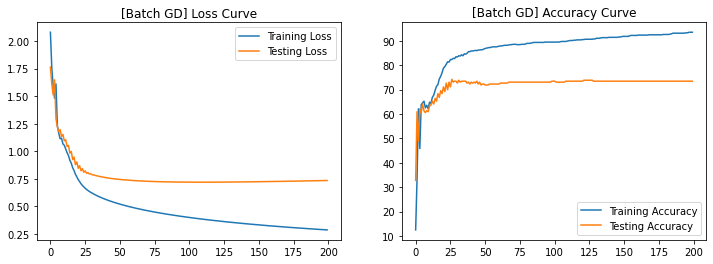

Optimization Algorithm: [Batch GD]
Train Acc: 93.4896, Train Loss:  0.2864
Test  Acc: 73.4375, Test  Loss:  0.7346

Training and testing...


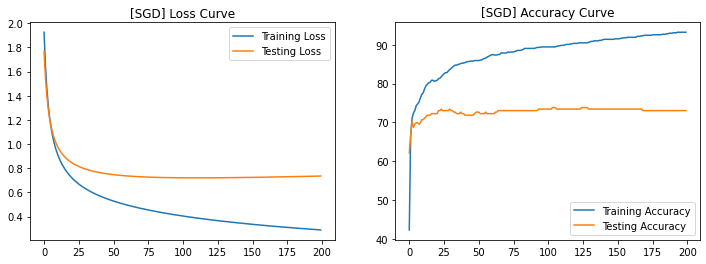

Optimization Algorithm: [SGD]
Train Acc: 93.2292, Train Loss:  0.2892
Test  Acc: 73.0469, Test  Loss:  0.7349

Training and testing...


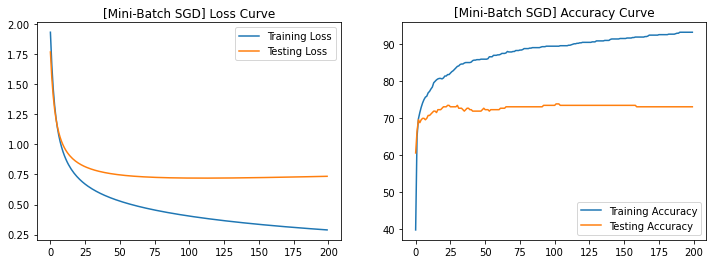

Optimization Algorithm: [Mini-Batch SGD]
Train Acc: 93.2292, Train Loss:  0.2894
Test  Acc: 73.0469, Test  Loss:  0.7345



In [10]:
optim_algorithms = ["Batch GD", "SGD", "Mini-Batch SGD"]

for algorithm in optim_algorithms:
    ## Build model, train & test
    model = LogisticRegression(epochs, batch_size, x_train.shape[0], learning_rate, algorithm)
    w, train_accs, train_losses, test_accs, test_losses = model.train_and_test(x_train, t_train, x_test, t_test)
    
    ## Show results
    model.plot_curve(train_accs, train_losses, test_accs, test_losses)
    print("Optimization Algorithm: [{}]".format(algorithm))
    print("Train Acc: {:7.4f}, Train Loss: {:7.4f}".format(train_accs[-1], train_losses[-1]))
    print("Test  Acc: {:7.4f}, Test  Loss: {:7.4f}".format(test_accs[-1], test_losses[-1]))
    print()

## 2. Gaussian Process for Regression

### 2.0 Data Preprocessing

In [11]:
###############
## Load Data ##
###############
data_x_df = pd.read_csv("./gaussian_process_data/x.csv", header=None)
data_t_df = pd.read_csv("./gaussian_process_data/t.csv", header=None)

print("x shape: {}".format(data_x_df.shape))
print("t shape: {}".format(data_t_df.shape))

x shape: (300, 1)
t shape: (300, 1)


In [12]:
############################
## Split train & test set ##
############################
def split_train_test(data_x_df, data_t_df, num_train):
    """Input type: Pandas.dataframe"""
    x_arr = data_x_df.to_numpy()
    t_arr = data_t_df.to_numpy()
    
    x_train, x_test = x_arr[:num_train], x_arr[num_train:]
    t_train, t_test = t_arr[:num_train], t_arr[num_train:]
    
    return x_train, t_train, x_test, t_test

In [13]:
num_train = 150
x_train, t_train, x_test, t_test = split_train_test(data_x_df, data_t_df, num_train)
print("# of training: {}".format(x_train.shape))
print("# of testing : {}".format(x_test.shape))

# of training: (150, 1)
# of testing : (150, 1)


### 2.1 Kernel Function with Polynomial Basis of Order 2

In [14]:
class GaussianProcessForRegression(object):
    def __init__(self, kernel, thetas=None):
        """Initialize model."""
        self.kernel_name = kernel ## polynomial, exponential-quadratic
        self.beta_inv = 1
        self.thetas = thetas ## hyperparameters for exponential-quadratic kernel
    
    def kernel(self, xn, xm):
        """
        Return different kernel matrix according to self.kernel_name.
        Input:
            xn: 2d-matrix, shape: (# data, 1)
            xm: 2d-matrix, shape: (# data, 1)
        """
        if self.kernel_name == "polynomial":
            ## xn.shape: (150, 1), xm.shape: (150, 1)
            phi_xn = np.concatenate((np.ones(xn.shape), xn, np.power(xn, 2)), axis=1) ## (150, 3)
            phi_xm = np.concatenate((np.ones(xm.shape), xm, np.power(xm, 2)), axis=1) ## (150, 3)
            kernel = phi_xn.dot(phi_xm.T) ## (150, 150)

        elif self.kernel_name == "exponential-quadratic":
            ## xn.shape: (150, 1), xm.shape: (150, 1) -> kernel.shape: (150, 150)
            ## xn.shape: (150, 1), xm.shape: (1  , 1) -> kernel.shape: (150, 1  )
            sub_outer  = np.subtract.outer(xn.flatten(), xm.flatten()) ## subtract of all combinations
            kernel = self.thetas[0] * np.exp((-1) * self.thetas[1] / 2 * np.power(sub_outer, 2)) + \
                     self.thetas[2] + self.thetas[3] * xn.dot(xm.T)
            
        return kernel
    
    def train(self, x_train, t_train):
        """Find covariance matrix for training set."""
        k = self.kernel(x_train, x_train)
        cov = k + self.beta_inv * np.eye(k.shape[0]) ## (150, 150)
        return cov
    
    def predict(self, x_train, t_train, cov, x_test):
        """
        Find mean and standard deviation for predictive distribution on each sample.
        Input:
            x_train: training input , shape: (150, 1)
            t_train: training target, shape: (150, 1)
            cov    : covariance matrix of training set, shape: (150, 150)
            x_test : input to be predicted, shape: (150, 1)
        """
        means, stds = [], []
        cov_inv = np.linalg.inv(cov)
        
        for xn in x_test:
            k = self.kernel(x_train, xn.reshape(1, 1))
            mean = k.T.dot(cov_inv).dot(t_train)
            std  = np.sqrt(self.kernel(xn.reshape(1, 1), xn.reshape(1, 1)) + self.beta_inv - k.T.dot(cov_inv).dot(k))
            
            means.append(mean.flatten()[0])
            stds.append(std.flatten()[0])
        
        means = np.array(means)
        stds  = np.array(stds)
        
        return means, stds
    
    def eval_rms(self, y, t):
        """Evaluate root-mean-square error. y and t should have same shape"""
        return np.sqrt(np.mean(np.power(y - t, 2)))
    
    def plot(self, x, t, x_test, means, stds, exp_idx=None):
        ## Predicted means and std range
        plt.plot(x_test.flatten(), means, "r-")
        plt.fill_between(x_test.flatten(), means + stds, means - stds, color="pink")
        
        ## Ground-truth
        plt.scatter(x, t)
        
        plt.xlabel("x")
        plt.ylabel("t")
        
        if self.kernel_name == "polynomial":
            plt.title("Kernel with polynomial basis of order 2")
            plt.savefig("./result/gp_poly.png", dpi=300)
        elif self.kernel_name == "exponential-quadratic":
            plt.title(r"$\theta$ = [{}, {}, {}, {}]".format
                      (self.thetas[0], self.thetas[1], self.thetas[2], self.thetas[3]))
            plt.savefig("./result/gp_exp_{}.png".format(exp_idx), dpi=300)
        plt.show()

In [15]:
## To be predicted, range: (0, 10)
x_valid = np.linspace(0, 10, 150).reshape(150, 1)

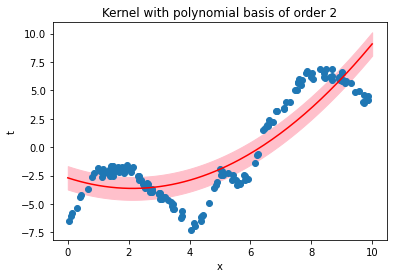

In [16]:
## Fit on training set
model = GaussianProcessForRegression(kernel="polynomial")
cov = model.train(x_train, t_train)
means, stds = model.predict(x_train, t_train, cov, x_valid)
model.plot(x_train, t_train, x_valid, means, stds)

In [17]:
## Evaluate root-mean-square error
train_means, _ = model.predict(x_train, t_train, cov, x_train)
test_means , _ = model.predict(x_train, t_train, cov, x_test)

train_rms = model.eval_rms(train_means, t_train.flatten())
test_rms = model.eval_rms(test_means, t_test.flatten())
print("Training RMSE: {:.4f}, Testing RMSE: {:.4f}".format(train_rms, test_rms))

Training RMSE: 2.0664, Testing RMSE: 2.0971


### 2.2 Exponential-Quadratic Kernel Function

In [18]:
thetas_combs = [
    [0, 0, 0, 1],
    [1, 8, 0, 0],
    [1, 1, 0, 16],
    [1, 1, 32, 0], 
    [35, 2, 0, 0] ## best hyperparameters by trial & error
]

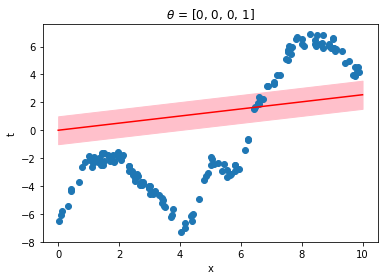

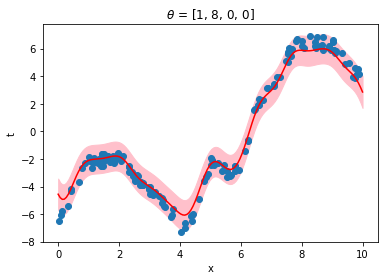

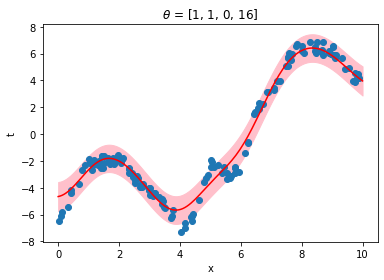

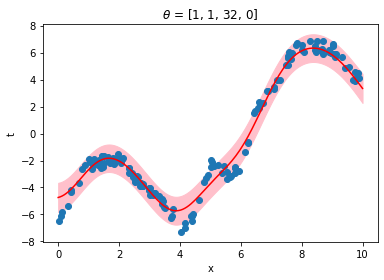

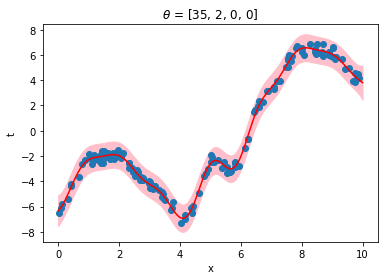

In [19]:
for idx, thetas in enumerate(thetas_combs):
    model = GaussianProcessForRegression(kernel="exponential-quadratic", thetas=thetas)
    cov = model.train(x_train, t_train)
    means, stds = model.predict(x_train, t_train, cov, x_valid)
    model.plot(x_train, t_train, x_valid, means, stds, idx)

In [20]:
## Evaluate root-mean-square error
for idx, thetas in enumerate(thetas_combs):
    model = GaussianProcessForRegression(kernel="exponential-quadratic", thetas=thetas)
    cov = model.train(x_train, t_train)
    
    train_means, _ = model.predict(x_train, t_train, cov, x_train)
    test_means , _ = model.predict(x_train, t_train, cov, x_test)
    
    train_rms = model.eval_rms(train_means, t_train.flatten())
    test_rms = model.eval_rms(test_means, t_test.flatten())
    
    if idx == len(thetas_combs) - 1:
        print("\n---Best combinations of hyperparameters by trial and error---\n")
    print("Thetas: [{:2d}, {:2d}, {:2d}, {:2d}], Training RMSE: {:.4f}, Testing  RMSE: {:.4f}".format
          (thetas[0], thetas[1], thetas[2], thetas[3], train_rms, test_rms))

Thetas: [ 0,  0,  0,  1], Training RMSE: 4.0827, Testing  RMSE: 3.9326
Thetas: [ 1,  8,  0,  0], Training RMSE: 0.4696, Testing  RMSE: 0.4930
Thetas: [ 1,  1,  0, 16], Training RMSE: 0.6045, Testing  RMSE: 0.5810
Thetas: [ 1,  1, 32,  0], Training RMSE: 0.6025, Testing  RMSE: 0.5866

---Best combinations of hyperparameters by trial and error---

Thetas: [35,  2,  0,  0], Training RMSE: 0.2737, Testing  RMSE: 0.3030
